In [1]:
from enum import Enum   

class System(Enum):
    PI3 = 1
    PI4 = 2
    FDP = 3

system_in_use = System.PI3

Get columns to check continuity on

In [2]:
check_b_probe_colummns = True
# other_columns = ['WBPol', 'q020', 'q050', 'q080', 'WBPolNoDCInFC', 'phiPlInFC']
other_columns = []

In [3]:
import os
import sys

sys.path.append(os.getenv("AURORA_REPOS"))

from flagships.post_processing import GenerateColumns

if(system_in_use == System.PI3):
    csv_generator =  GenerateColumns.PI3CSVGenerator()
elif(system_in_use == System.PI4):
    csv_generator =  GenerateColumns.PI4CSVGenerator()
elif(system_in_use == System.FDP):
    csv_generator = GenerateColumns.FDPCase22a_CSVGenerator()
else:
    print('Ensure correct system is set')

b_col_names = []
if check_b_probe_colummns:
    for val in csv_generator.add_bprobe_columns([]):
        b_col_names.append('B' + val[0])

profile_columns_of_interest = other_columns + b_col_names
existent_columns_of_interest = []

all_cols = csv_generator.create_all_columns()
all_col_names = [col.Name for col in all_cols]

for col_of_interest in profile_columns_of_interest:
    if(all_col_names.count(col_of_interest) != 0):
        existent_columns_of_interest.append(col_of_interest)

print('Found the following columns: ', existent_columns_of_interest)
','.join(existent_columns_of_interest)

Found the following columns:  ['B161087', 'B211100', 'B261087', 'B291060', 'B215008', 'B261008', 'B291008']


'B161087,B211100,B261087,B291060,B215008,B261008,B291008'

Create verification object

In [4]:
table_name = "pi3b_asbuilt_pfc17500ab_2022-06-09"

In [5]:

backend_cs_dll = os.path.join('bin', 'Debug')
sys.path.append(backend_cs_dll)

import clr
clr.AddReference('table_verification_cs')

from TableVerification import TableVerifier, FailingProfile

tv = TableVerifier(table_name, ','.join(existent_columns_of_interest))
print(f"Read {tv.GetNumRowsInDatatable()} Rows")


Read 1728457 Rows


Data Verification

In [6]:
tv.GenerateProfileScores()

In [9]:
failing_profiles = tv.GetFailingProfiles(.4)
print('Found ', len(failing_profiles) , ' failing profiles')

Found  1461  failing profiles


In [12]:
import sys, os
import matplotlib.pyplot as plt

sys.path.append(os.getenv("AURORA_REPOS"))

from flagships.post_processing.GenerateColumns import get_full_file_path
from flagships.post_processing.ParseFlagshipsFile import FlagshipsParser
from flagships.post_processing.EquilibriumPlotting import PlotPsi5PctContours

def plotPsiContoursForProfile(failing_profile : FailingProfile, axes):
    search_axis_name = failing_profile.SearchAxis
    search_axis_values = list(axes[search_axis_name])
    
    if search_axis_values.index(failing_profile.TableParams[search_axis_name]) == 0:
        offending_values = search_axis_values[:2]
    elif search_axis_values.index(failing_profile.TableParams[search_axis_name]) == len(search_axis_values)-1:
        offending_values = search_axis_values[len(search_axis_values)-2:]
    else:
        offending_values = search_axis_values[search_axis_values.index(failing_profile.TableParams[search_axis_name])-1:search_axis_values.index(failing_profile.TableParams[search_axis_name])+2]

    table_params = {}

    for search_axis in failing_profile.TableParams.Keys:
        table_params[search_axis] = failing_profile.TableParams[search_axis]

    i = 1
    plt.figure(figsize=(12, 6))
    for val in offending_values:
        table_params[failing_profile.SearchAxis] = val
        suffix = "." + os.path.normpath(failing_profile.FilesLocation).split(os.sep)[-2]
        prefix = ""
        lut_root = os.path.normpath(os.getenv('FS_ARCHIVE_ROOT') + os.path.sep + failing_profile.FilesLocation)
        filepath = get_full_file_path(lut_root=lut_root, prefix=prefix, suffix=suffix,
                soak = table_params['psieq_soak'], beta=table_params['beta_pol1_setpoint'], dc=table_params['psieq_dc'], NevinsC=table_params['NevinsC'], 
                NevinsAB=table_params['NevinsA'], NevinsN=table_params['NevinsN'], current_ratio=table_params['Ipl_setpoint']*1e-6)
        filepath = filepath.replace('\\', os.path.sep)
        if(not os.path.exists(filepath)):
            filepath = filepath[:filepath.find('ab', filepath.find('equil'))+3] + filepath[filepath.find('ab', filepath.find('equil'))+4:]
        if(not os.path.exists(filepath)):
            filepath = filepath[:filepath.rfind('ab')+3] + filepath[filepath.rfind('ab')+4:]
        if(not os.path.exists(filepath)):
            print(f'File cannot be found:\n {filepath}')
            continue

        parser = FlagshipsParser(filepath, filepath)
        plt.subplot(1, len(offending_values), i)
        PlotPsi5PctContours(parser)
        plt.scatter(parser.GetScalar('xpoint_r'), parser.GetScalar('xpoint_z'), marker='x') #TODO add this as a function to EquilmPlotting.py, but points dont look right
        plt.title(failing_profile.SearchAxis + f" = {val}")
        i += 1

# parser = plotPsiContoursForProfile(failing_profiles[10], tv.TableAxesValues)

View psi contours for failing plots

1461


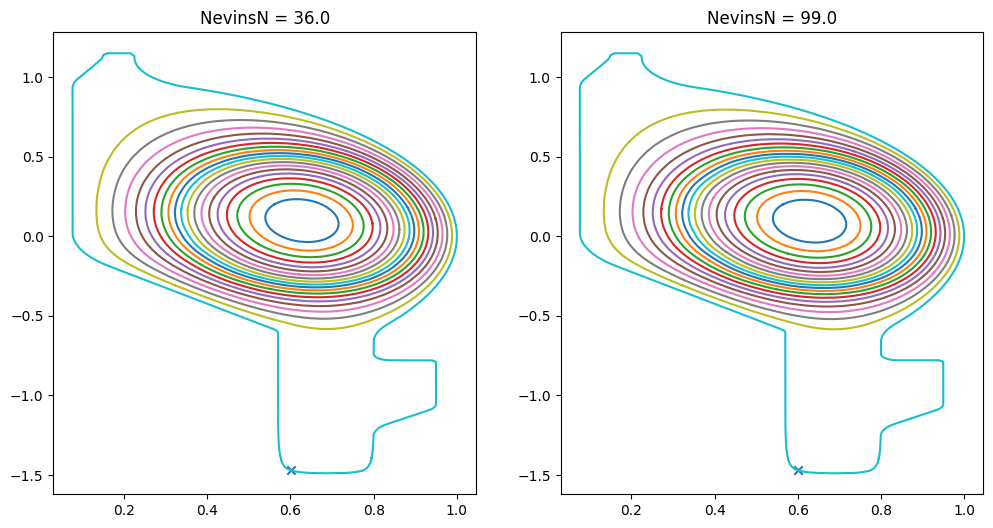

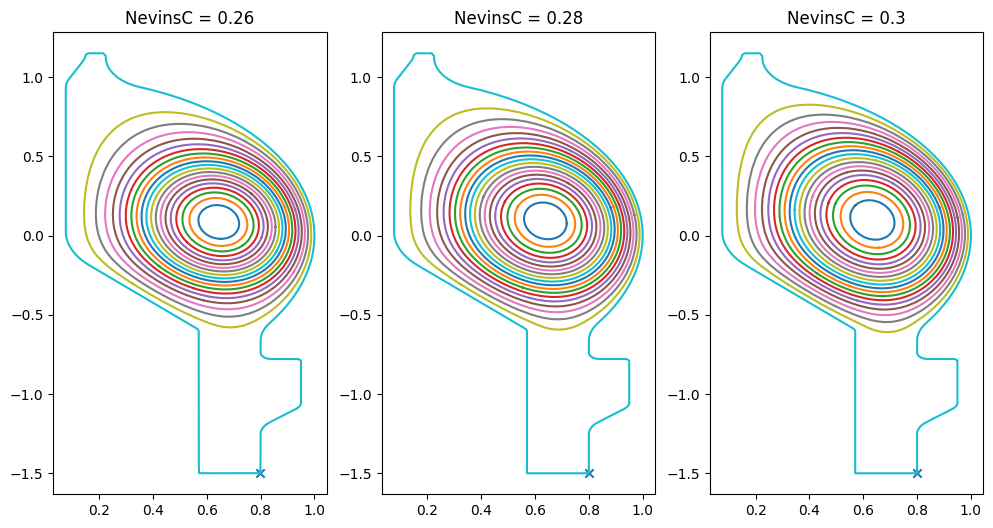

In [13]:
print(len(failing_profiles))

for failing_profile in failing_profiles:
    if(failing_profile.SearchAxis == 'NevinsN'): continue
    plotPsiContoursForProfile(failing_profile, tv.TableAxesValues)
    plt.show()
    in_key = input("Press Enter to continue...")
    if(in_key == 'end'):
        break

Work with Datatable object

In [10]:
# clr.AddReference('System.Memory')
# from System import

profile_scores = tv.GetProfileScoreTable()
print(f'Full table has {profile_scores.Rows.Count} rows')

threshold = 0.3
select_str = ''
for col in existent_columns_of_interest:
    select_str += f'{col} > {threshold} OR '
select_str = select_str[:-3]

failing_row_arr = profile_scores.Select(select_str)
failing_rows = profile_scores.Clone()
# check each column
num_fails = 0
b_cols = ['B161087','B211100','B261087','B291060','B215008','B261008','B291008']
for row in failing_row_arr:
    for b_col in b_cols:
        if row[b_col] > threshold:
            num_fails += 1
    failing_rows.ImportRow(row)

print(f'Table has {failing_rows.Rows.Count} failing rows')
print(f'Total fails: {num_fails}')

axes_names = [col.ColumnName for col in failing_rows.Columns][0:7]

cs_float_type = type(row[b_cols[0]])

# the search axis col is of type db.null (not float)
for axis_name in axes_names:
    num_fails = 0
    for row in failing_rows.Rows:
        if type(row[axis_name]) != cs_float_type:
            num_fails += 1
    print(f'{axis_name} has {num_fails} fails')

Full table has 17699 rows
Table has 1349 failing rows
Total fails: 3473
psieq_soak has 26 fails
beta_pol1_setpoint has 0 fails
psieq_dc has 32 fails
NevinsA has 11 fails
NevinsC has 486 fails
NevinsN has 773 fails
Ipl_setpoint has 21 fails


1. Check for holes in the data

In [ ]:
print(type(float))

2. Check for data discontinuities